- [Float to bits](https://stackoverflow.com/questions/16444726/binary-representation-of-float-in-python-bits-not-hex)
- [Paper 1](https://arxiv.org/pdf/2107.08590.pdf)
- [Paper 2](https://arxiv.org/pdf/2109.04344v2.pdf)

In [1]:
import math
import random
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

from stego import FloatBinary, str_to_bits, bits_to_str

# Float modification

## Test the implementation

### Convert value to the new type - see how the reconstruction goes

In [2]:
v = -99.89
x = FloatBinary(v)

print(f"Reconstructed float: {x.reconstruct_float_value()}")
print(f"Diff of original and reconstructed: {abs(v - x.reconstruct_float_value())}")

Reconstructed float: -99.88999938964844
Diff of original and reconstructed: 6.103515630684342e-07


### Investigate the range for the float value when changing the last K bits

In [3]:
# Bits to modify from fraction
k = 16

f_0 = x.fraction[:7] + (False,) * k
print(f"Last {k} bits are 0s: {x.modify_clone(fraction=f_0).v}")

f_1 = x.fraction[:7] + (True,) * k
print(f"Last {k} bits are 1s: {x.modify_clone(fraction=f_1).v}")

f_r = x.fraction[:7] + tuple(random.choices([True, False], k=k))
print(f"Last {k} bits are random 0/1: {x.modify_clone(fraction=f_r).v}")

Last 16 bits are 0s: -99.5
Last 16 bits are 1s: -99.99999237060547
Last 16 bits are random 0/1: -99.95637512207031


In [4]:
tmp = []

for _ in range(1000):
    f_r = x.fraction[:7] + tuple(random.choices([True, False], k=k))
    tmp.append(x.modify_clone(fraction=f_r).v)

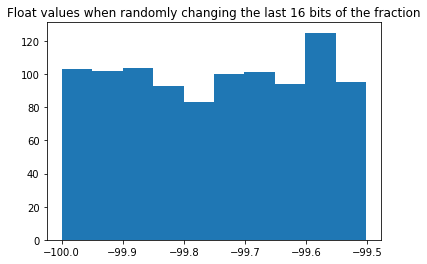

In [5]:
plt.hist(tmp)
plt.title(f"Float values when randomly changing the last {k} bits of the fraction");

# "Hide" a string in a list of float values

In [6]:
# Test
test_str: str = "I am Gabor, this is a test"
assert bits_to_str(str_to_bits(test_str)) == test_str, "Reconstructed is not the same string"

## The data

In [7]:
# Text we want to hide
s_to_hide = "I am Gabor and I want to add this to the model. Let's see how it goes, hopefully we can recover the message."

In [8]:
s_bits = str_to_bits(s_to_hide)
print(f"Text to hide is {len(s_bits)} bits -- {len(s_bits)/8} bytes")

Text to hide is 864 bits -- 108.0 bytes


## Let's hide it

In [9]:
# String as a list of bits
s_bits = str_to_bits(s_to_hide, as_list=False)
# Bits to use from the fraction of the float value 
nb_bits_to_modify_from_fraction:int = 8
assert nb_bits_to_modify_from_fraction <= 23, "Number of bits can't be bigger the number of bits in the fraction"

In [10]:
# This is how many values are needed to recover the hidden string
nb_vales_needed:int = math.ceil(len(s_bits) / nb_bits_to_modify_from_fraction)

In [11]:
print(f"(minimum) Number of data points needed: {nb_vales_needed} (32bit float values)")

(minimum) Number of data points needed: 108 (32bit float values)


In [12]:
# Data what we can modify and hide the text by modifying float bits
data = [random.uniform(-1, 1) for _ in range(nb_vales_needed)]

In [13]:
# Using only the last N bits of each float value
theoretical_max_hide_size = len(data) * nb_bits_to_modify_from_fraction
print(f"Theoretical max text size to hide is {theoretical_max_hide_size} bits - {theoretical_max_hide_size/8} bytes")

Theoretical max text size to hide is 864 bits - 108.0 bytes


In [14]:
modified_data: List[float] = []
last_modified_index:int = -1

for i in range(nb_vales_needed):
    _from_index = i * nb_bits_to_modify_from_fraction
    _to_index = _from_index + nb_bits_to_modify_from_fraction
    bits_to_hide = s_bits[_from_index:_to_index]
    bits_to_hide = list(map(bool, bits_to_hide))
    
    x = FloatBinary(data[i])
    
    fraction_modified = list(x.fraction)
    fraction_modified[-nb_bits_to_modify_from_fraction:] = bits_to_hide
    x_modified = x.modify_clone(fraction=tuple(fraction_modified))
    modified_data.append(x_modified.v)
last_modified_index = i

### Change in the float values

In [15]:
diff = np.array(modified_data) - np.array(data)
diff_abs = np.abs(diff)

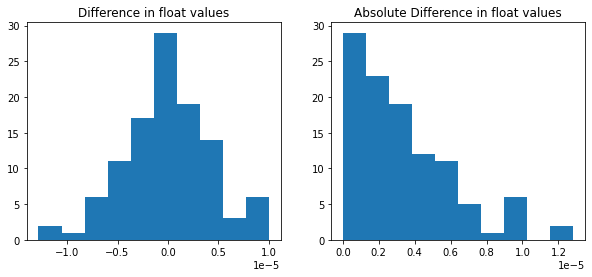

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(diff)
axs[0].set_title("Difference in float values")
axs[1].hist(diff_abs)
axs[1].set_title("Absolute Difference in float values");

In [17]:
print(f"Min diff: {diff_abs.min()}")
print(f"Max diff: {diff_abs.max()}")
print(f"Mean diff: {diff_abs.mean()}")

Min diff: 2.9401250323246586e-09
Max diff: 1.2833609038143123e-05
Mean diff: 3.289027981075217e-06


## Recover the message

In [18]:
hidden_data: List[bool] = []

for d in modified_data:
    x = FloatBinary(d)
    hidden_bits = x.fraction[-nb_bits_to_modify_from_fraction:]
    hidden_data.extend(hidden_bits)

In [19]:
recovered_message: str = bits_to_str(list(map(int, hidden_data)))

In [22]:
print(f"Recovered string:\n'{recovered_message}'")

Recovered string:
'I am Gabor and I want to add this to the model. Let's see how it goes, hopefully we can recover the message.'


In [20]:
assert recovered_message == s_to_hide, "Recovered message is not the same as the original one"